In [36]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import konlpy
import sentencepiece as spm
import os

from tensorflow.keras.optimizers import Adam
from konlpy.tag import Mecab

%matplotlib inline

In [2]:
train = pd.read_table('~/aiffel/sp_tokenizer/data/nsmc/ratings_train.txt', sep = '\t')
test = pd.read_table('~/aiffel/sp_tokenizer/data/nsmc/ratings_test.txt', sep = '\t')

display(train.head())
display(test.head())

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


,id,document,label
0,6270596,굳 ㅋ,1
1,9274899,GDNTOPCLASSINTHECLUB,0
2,8544678,뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아,0
3,6825595,지루하지는 않은데 완전 막장임... 돈주고 보기에는....,0
4,6723715,3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??,0


In [3]:
train = train.dropna(subset=['document'])
test = test.dropna(subset = ['document'])

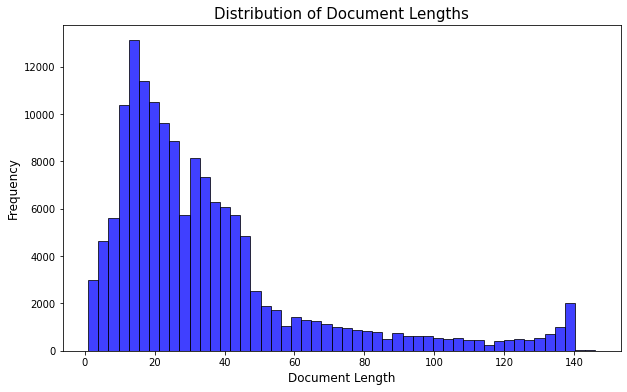

In [4]:
# 문장 길이 계산
train['document_length'] = train['document'].apply(len)

# 문장 길이의 분포 시각화
plt.figure(figsize=(10, 6))
plt.hist(train['document_length'], bins=50, alpha=0.75, color='b', edgecolor='black')
plt.title("Distribution of Document Lengths", fontsize=15)
plt.xlabel("Document Length", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.show()

In [5]:
# mecab = Mecab()

In [6]:
def tokenize(corpus):  # corpus: Tokenized Sentence's List
    tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='')
    tokenizer.fit_on_texts(corpus)

    tensor = tokenizer.texts_to_sequences(corpus)

    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='pre')

    return tensor, tokenizer

In [7]:
# 학습 데이터를 하나의 텍스트 파일로 저장
with open('train_text.txt', 'w', encoding='utf-8') as f:
    for sentence in train['document']:
        # 모든 데이터를 문자열로 변환하여 저장
        f.write(str(sentence) + '\n')

# SentencePiece 모델 학습
spm.SentencePieceTrainer.train(input='train_text.txt', model_prefix='spm_model', vocab_size=8000, model_type='bpe')

sentencepiece_trainer.cc(77) LOG(INFO) Starts training with : 
trainer_spec {
  input: train_text.txt
  input_format: 
  model_prefix: spm_model
  model_type: BPE
  vocab_size: 8000
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  required_chars: 
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  train_extremely_large_corpus: 0
  hard_vocab_limit: 1
  use_all_vocab: 0
  unk_id: 0
  bos_id: 1
  eos_id: 2
  pad_id: -1
  unk_piece: <unk>
  bos_piece: <s>
  eos_piece: </s>
  pad_piece: <pad>
  unk_surface:  ⁇ 
}
normalizer_spec {
  name: nmt_nfkc
  add_dummy_prefix: 1
  remove_extra_whitespaces: 1
  escape_wh

In [14]:
sp = spm.SentencePieceProcessor()
sp.load('spm_model.model')

tokensIDs = sp.EncodeAsIds('아버지가방에들어가신다.')
print(tokensIDs)

# SentencePiece를 활용한 sentence -> encoded pieces
print(sp.SampleEncodeAsPieces('아버지가방에들어가신다.',1, 0.0))

# SentencePiece를 활용한 encoding -> sentence 복원
print(sp.DecodeIds(tokensIDs))

[4862, 883, 6555, 6301, 1413, 6297, 6398, 6291, 6289]
['▁아버', '지가', '방', '에', '들어', '가', '신', '다', '.']
아버지가방에들어가신다.


In [30]:
# Mecab과 SentencePiece를 결합한 토크나이저 함수
def sp_tokenize_with_mecab(s, corpus):
    """
    Mecab으로 형태소 분석 후, SentencePiece로 토크나이징을 수행하여 패딩 처리한 텐서를 반환하는 함수
    s : 학습된 SentencePiece 모델
    corpus : 문장의 리스트

    반환값:
    tensor : 토크나이징된 텐서
    word_index : 각 단어에 매핑된 인덱스
    index_word : 각 인덱스에 매핑된 단어
    """
    tensor = []
    
    # Mecab으로 형태소 분석 후 SentencePiece로 토크나이징
    for sen in corpus:
        mecab_tokens = mecab.morphs(sen)  # Mecab으로 형태소 분석
        sentence_pieces = ' '.join(mecab_tokens)  # 형태소를 공백으로 연결
        tensor.append(s.EncodeAsIds(sentence_pieces))  # 형태소 분석된 문장을 SentencePiece로 토큰 ID로 변환

    # 단어 사전 불러오기 (SentencePiece에서 학습된 vocab 파일 사용)
    with open("./spm_model.vocab", 'r') as f:
        vocab = f.readlines()

    word_index = {}
    index_word = {}

    # vocab 파일에서 단어-인덱스 매핑 생성
    for idx, line in enumerate(vocab):
        word = line.split("\t")[0]
        word_index.update({word: idx})
        index_word.update({idx: word})

    # 텐서 패딩 처리 (길이가 다른 문장을 동일한 길이로 맞춰줌)
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='pre')

    return tensor, word_index, index_word

In [31]:
# 학습 데이터와 테스트 데이터에 sp_tokenize_with_mecab 적용
train_tensor, train_word_index, train_index_word = sp_tokenize_with_mecab(sp, train['document'].tolist())
test_tensor, test_word_index, test_index_word = sp_tokenize_with_mecab(sp, test['document'].tolist())

# 레이블 준비
train_labels = tf.convert_to_tensor(train['label'].values)
test_labels = tf.convert_to_tensor(test['label'].values)

In [32]:
print("Train tensor shape:", train_tensor.shape)
print("Test tensor shape:", test_tensor.shape)

Train tensor shape: (149995, 239)
Test tensor shape: (49997, 141)


### LSTM

In [37]:
model_lstm = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=len(train_word_index), output_dim=128, input_length=train_tensor.shape[1]),
    tf.keras.layers.LSTM(128),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid') 
])

optimizer = Adam(learning_rate = 3e-4)
model_lstm.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# 모델 학습
history_lstm = model_lstm.fit(train_tensor, train_labels, epochs = 5, batch_size = 128, validation_split = 0.2)

model_lstm.summary()

Epoch 1/5
938/938 [==============================] - 19s 18ms/step - loss: 0.4048 - accuracy: 0.8192 - val_loss: 0.3503 - val_accuracy: 0.8465
Epoch 2/5
938/938 [==============================] - 17s 18ms/step - loss: 0.3245 - accuracy: 0.8619 - val_loss: 0.3266 - val_accuracy: 0.8579
Epoch 3/5
938/938 [==============================] - 17s 19ms/step - loss: 0.2903 - accuracy: 0.8770 - val_loss: 0.3220 - val_accuracy: 0.8636
Epoch 4/5
938/938 [==============================] - 18s 19ms/step - loss: 0.2630 - accuracy: 0.8906 - val_loss: 0.3346 - val_accuracy: 0.8581
Epoch 5/5
938/938 [==============================] - 17s 19ms/step - loss: 0.2384 - accuracy: 0.9013 - val_loss: 0.3423 - val_accuracy: 0.8647
Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 239, 128)          1024000   
_________________________________________________________________

In [38]:
loss, accuracy = model_lstm.evaluate(test_tensor, test_labels)
print(f"Test Accuracy: {accuracy:.4f}")

1563/1563 [==============================] - 7s 4ms/step - loss: 0.3452 - accuracy: 0.8596
Test Accuracy: 0.8596


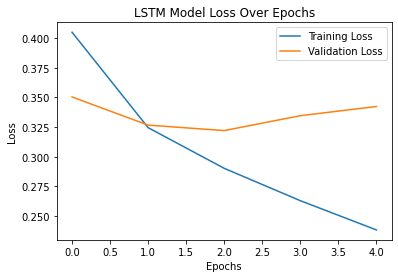

In [39]:
plt.plot(history_lstm.history['loss'], label='Training Loss')
plt.plot(history_lstm.history['val_loss'], label='Validation Loss')
plt.title('LSTM Model Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### BiLSTM

In [40]:
model_bilstm = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=8000, output_dim=128, input_length=train_tensor.shape[1]),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True)),  # Bidirectional LSTM 적용
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model_bilstm.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# 모델 학습
history_bilstm = model_lstm.fit(train_tensor, train_labels, epochs = 5, batch_size = 64, validation_split = 0.2)

model_bilstm.summary()

Epoch 1/5
1875/1875 [==============================] - 24s 13ms/step - loss: 0.2379 - accuracy: 0.9014 - val_loss: 0.3558 - val_accuracy: 0.8622
Epoch 2/5
1875/1875 [==============================] - 24s 13ms/step - loss: 0.2077 - accuracy: 0.9158 - val_loss: 0.3710 - val_accuracy: 0.8579
Epoch 3/5
1875/1875 [==============================] - 24s 13ms/step - loss: 0.1844 - accuracy: 0.9261 - val_loss: 0.4060 - val_accuracy: 0.8523
Epoch 4/5
1875/1875 [==============================] - 25s 13ms/step - loss: 0.1607 - accuracy: 0.9361 - val_loss: 0.4610 - val_accuracy: 0.8509
Epoch 5/5
1875/1875 [==============================] - 24s 13ms/step - loss: 0.1377 - accuracy: 0.9455 - val_loss: 0.5035 - val_accuracy: 0.8549
Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 239, 128)          1024000   
_______________________________________________________

In [41]:
loss, accuracy = model_bilstm.evaluate(test_tensor, test_labels)
print(f"Test Accuracy: {accuracy:.4f}")

1563/1563 [==============================] - 16s 9ms/step - loss: 0.6930 - accuracy: 0.5045
Test Accuracy: 0.5045


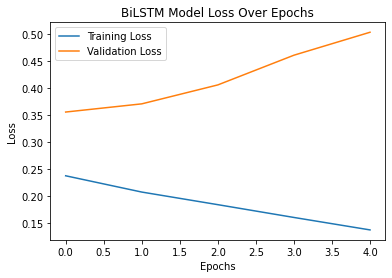

In [42]:
plt.plot(history_bilstm.history['loss'], label='Training Loss')
plt.plot(history_bilstm.history['val_loss'], label='Validation Loss')
plt.title('BiLSTM Model Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### SentencePieceTrainer 'character'

In [43]:
# character방식은 문자를 개별적으로 토큰으로 처리
spm.SentencePieceTrainer.train(input='train_text.txt', model_prefix='spm_model_char', vocab_size=8000, model_type='char')

In [44]:
sp = spm.SentencePieceProcessor()
sp.load('spm_model.model')

tokensIDs = sp.EncodeAsIds('아버지가방에들어가신다.')
print(tokensIDs)

# SentencePiece를 활용한 sentence -> encoded pieces
print(sp.SampleEncodeAsPieces('아버지가방에들어가신다.',1, 0.0))

# SentencePiece를 활용한 encoding -> sentence 복원
print(sp.DecodeIds(tokensIDs))

[4862, 883, 6555, 6301, 1413, 6297, 6398, 6291, 6289]
['▁아버', '지가', '방', '에', '들어', '가', '신', '다', '.']
아버지가방에들어가신다.


In [45]:
# Mecab과 SentencePiece를 결합한 토크나이저 함수
def sp_tokenize_with_mecab(s, corpus):
    """
    Mecab으로 형태소 분석 후, SentencePiece로 토크나이징을 수행하여 패딩 처리한 텐서를 반환하는 함수
    s : 학습된 SentencePiece 모델
    corpus : 문장의 리스트

    반환값:
    tensor : 토크나이징된 텐서
    word_index : 각 단어에 매핑된 인덱스
    index_word : 각 인덱스에 매핑된 단어
    """
    tensor = []
    
    # Mecab으로 형태소 분석 후 SentencePiece로 토크나이징
    for sen in corpus:
        mecab_tokens = mecab.morphs(sen)  # Mecab으로 형태소 분석
        sentence_pieces = ' '.join(mecab_tokens)  # 형태소를 공백으로 연결
        tensor.append(s.EncodeAsIds(sentence_pieces))  # 형태소 분석된 문장을 SentencePiece로 토큰 ID로 변환

    # 단어 사전 불러오기 (SentencePiece에서 학습된 vocab 파일 사용)
    with open("./spm_model.vocab", 'r') as f:
        vocab = f.readlines()

    word_index = {}
    index_word = {}

    # vocab 파일에서 단어-인덱스 매핑 생성
    for idx, line in enumerate(vocab):
        word = line.split("\t")[0]
        word_index.update({word: idx})
        index_word.update({idx: word})

    # 텐서 패딩 처리 (길이가 다른 문장을 동일한 길이로 맞춰줌)
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='pre')

    return tensor, word_index, index_word

In [46]:
# 학습 데이터와 테스트 데이터에 sp_tokenize_with_mecab 적용
train_tensor, train_word_index, train_index_word = sp_tokenize_with_mecab(sp, train['document'].tolist())
test_tensor, test_word_index, test_index_word = sp_tokenize_with_mecab(sp, test['document'].tolist())

# 레이블 준비
train_labels = tf.convert_to_tensor(train['label'].values)
test_labels = tf.convert_to_tensor(test['label'].values)

In [47]:
print("Train tensor shape:", train_tensor.shape)
print("Test tensor shape:", test_tensor.shape)

Train tensor shape: (149995, 239)
Test tensor shape: (49997, 141)


In [51]:
model_lstm = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=len(train_word_index), output_dim=128, input_length=train_tensor.shape[1]),
    tf.keras.layers.LSTM(128),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid') 
])

optimizer = Adam(learning_rate = 3e-4)
model_lstm.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# 모델 학습
history_lstm = model_lstm.fit(train_tensor, train_labels, epochs = 5, batch_size = 128, validation_split = 0.2)

model_lstm.summary()

Epoch 1/5
938/938 [==============================] - 18s 18ms/step - loss: 0.3924 - accuracy: 0.8233 - val_loss: 0.3394 - val_accuracy: 0.8492
Epoch 2/5
938/938 [==============================] - 17s 18ms/step - loss: 0.3135 - accuracy: 0.8658 - val_loss: 0.3169 - val_accuracy: 0.8613
Epoch 3/5
938/938 [==============================] - 17s 18ms/step - loss: 0.2800 - accuracy: 0.8815 - val_loss: 0.3267 - val_accuracy: 0.8572
Epoch 4/5
938/938 [==============================] - 17s 18ms/step - loss: 0.2526 - accuracy: 0.8946 - val_loss: 0.3233 - val_accuracy: 0.8645
Epoch 5/5
938/938 [==============================] - 17s 19ms/step - loss: 0.2285 - accuracy: 0.9056 - val_loss: 0.3472 - val_accuracy: 0.8612
Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, 239, 128)          1024000   
_________________________________________________________________

In [52]:
loss, accuracy = model_lstm.evaluate(test_tensor, test_labels)
print(f"Test Accuracy: {accuracy:.4f}")

1563/1563 [==============================] - 7s 4ms/step - loss: 0.3502 - accuracy: 0.8591
Test Accuracy: 0.8591


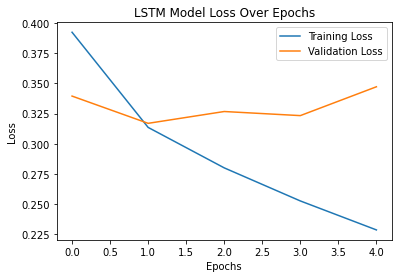

In [53]:
plt.plot(history_lstm.history['loss'], label='Training Loss')
plt.plot(history_lstm.history['val_loss'], label='Validation Loss')
plt.title('LSTM Model Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### 회고
- 정확도가 0.5에서 안 올라서 뭐가 문제인가에 대해 고민을 정말 했다.
- SentencePiece 만을 사용해서 정확도를 높여야하는 것인지 모르겠지만 
- Mecab을 함께 사용하니 높은 수준으로 향상했다.
- SentencePiece는 BPE와 Character 두 가지 방법으로 진행해보았는데 성능의 큰 차이는 느껴지지 않았고
- BPE는 자주 등장하는 문장 쌍을 점진적으로 병합하여 새로운 서브워드를 생성하는 방식
- Character는 모든 문자를 개별적으로 토큰화하는 방식임을 알게 되었다.
- 이렇게 진행하는 것이 맞는 것인지는 모르겠다.
- 배움의 재미가 있다.